In [1]:
#import libraries
import pandas as pd
import seaborn as sns
%matplotlib inline
import numpy as np
from sklearn.metrics import roc_auc_score
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import math
import math
n_samples = 100
from scipy.stats import chi2_contingency

#helpers for calculating metrics
def calculate_metrics(list_o, list_d):
    
    return 100*sum(list_o)/len(list_o),\
    100*sum(list_d)/len(list_d),\
    ((100 - 100*sum(list_o)/len(list_o))+  100*sum(list_d)/len(list_d))/2
    
def bootstrap_CI(list_o, list_d):
    us = []
    ms = []
    rs = []
    
    for i in range(n_samples):
        list_o_tmp = list_o.sample(len(list_o), replace = True)
        list_d_tmp = list_d.iloc[list_o_tmp.index]

        us.append(sum(list_o_tmp)/len(list_o_tmp))
        ms.append(sum(list_d_tmp)/len(list_d_tmp))
        rs.append((100*sum(list_d_tmp)/len(list_d_tmp) + (100 - sum(list_o_tmp)/len(list_o_tmp)))/2)
        
    return [100*np.nanpercentile(us,2.5), 100*np.nanpercentile(us,97.5),\
        100*np.nanpercentile(ms,2.5), 100*np.nanpercentile(ms,97.5),\
        np.nanpercentile(rs,2.5), np.nanpercentile(rs,97.5),\
        100*np.nanpercentile(us,50), \
        100*np.nanpercentile(ms,50), \
        np.nanpercentile(rs,50)]

def add_noise(value):
    noise = np.random.uniform(1,1)  # Adjust the range as needed
    return value + noise

#load the classifications
table = pd.read_csv('data/task2.csv')

### Calculate metrics for the hate subtask

In [2]:
df = table.loc[table.subtask=='hate'].reset_index()

models = ['perspective_insult','perspective_toxicity',
          'perspective_identity_attack',
           'score_tomh/toxigen_hatebert', 
           'label_gpt3.5',
           'label_gpt4','label_gpt3.5instruct',
            'score_facebook/roberta-hate-speech-dynabench-r4-target']

thresholds = [0.3,0.3,0.3,0.5,0.5,0.5,0.5,0.5]

list_entries = []
for cnt,model in enumerate(models):
    entry = {}
    entry['task'] = 'hate speech'
    entry['model'] = model
    
    for name,gr in df.sort_values(by = 'text_original').groupby('type'):
        if name=='disapproving':
            list_d =  gr[model]> thresholds[cnt]
        elif name=='original':
            list_o =  gr[model]> thresholds[cnt]
           
    flagged_u, flagged_m, avg = calculate_metrics(list_o, list_d)
    
    entry['False positive rate'] = flagged_m
    entry['False negative rate'] = 100-flagged_u
    entry['Average error rate'] = avg

    entry["False negative rate"+" lower"], entry["False negative rate"+" upper"], entry["False positive rate"+" lower"], entry["False positive rate"+" upper"],\
    entry["Average error rate"+" lower"], entry["Average error rate"+" upper"],  entry["False negative rate"+" median"],  entry["False positive rate"+" median"],entry["Average error rate"+"_median"] = \
    bootstrap_CI(list_o, list_d)
    
    list_entries.append(entry)

In [3]:
res = pd.DataFrame(list_entries)
res['False positive rate error'] = (res['False positive rate upper'] - res['False positive rate lower'])/2
res['False negative rate error'] = (res['False negative rate upper'] - res['False negative rate lower'])/2
res['Average error rate error'] = (res['False positive rate error'] + res['False negative rate error'])/2

In [4]:
(res[['task', 'model', 'False positive rate', 'False positive rate error',
      'False negative rate','False negative rate error',  
      'Average error rate','Average error rate error']].sort_values(by = 'Average error rate', ascending = False)).round(2)

,task,model,False positive rate,False positive rate error,False negative rate,False negative rate error,Average error rate,Average error rate error
3,hate speech,score_tomh/toxigen_hatebert,24.44,8.62,77.78,8.07,51.11,8.35
0,hate speech,perspective_insult,4.44,3.62,61.11,8.62,32.78,6.12
1,hate speech,perspective_toxicity,20.00,9.47,36.67,10.90,28.33,10.19
2,hate speech,perspective_identity_attack,21.11,9.47,33.33,8.89,27.22,9.18
7,hate speech,score_facebook/roberta-hate-speech-dynabench-r...,17.78,8.07,26.67,8.63,22.22,8.35
6,hate speech,label_gpt3.5instruct,25.56,9.44,13.33,6.67,19.44,8.06
4,hate speech,label_gpt3.5,11.11,6.69,22.22,8.07,16.67,7.38
5,hate speech,label_gpt4,8.89,6.14,20.00,9.44,14.44,7.79


In [5]:
labels_clean = {
    "score_tomh/toxigen_hatebert": "toxigen hatebert",
    "perspective_identity_attack": "perspective (identity attack)",
    "perspective_toxicity": "perspective (toxicity)",
    "label_gpt3.5instruct": "gpt-3.5-instruct-turbo",
    "score_facebook/roberta-hate-speech-dynabench-r4-target": "roberta hate speech",
    "label_gpt3.5": "gpt-3.5-turbo (ChatGPT 3.5)",
    "perspective_insult": "perspective (insult)",
    "label_gpt4": "gpt-4",
}

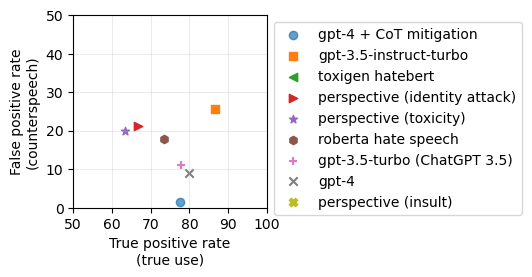

In [6]:
mStyles = [".",",","<",">","*","h","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11
]


fig, ax = plt.subplots(1,1,figsize= (2.5,2.5))

def add_noise(value):
    noise = np.random.uniform(1,1)  # Adjust the range as needed
    return value + noise


plt.scatter(80.00 *(1- 0.0299), 8.89*(1 - 0.8261),  marker='o', alpha = 0.7,label = 'gpt-4 + CoT mitigation') 

cnt=0
for index, row in res.sort_values(by = 'False positive rate',ascending = False).iterrows():
    cnt+=1

    plt.scatter(100-row['False negative rate'], row['False positive rate'],  marker=mStyles[cnt], 
                alpha = 1,label = labels_clean[row['model']])

plt.legend(bbox_to_anchor = (1,1))
    
plt.plot([0,100],[0,100], linestyle = '--', color = 'gray')
plt.xlim([50,100])
plt.ylim([0,50])

plt.xticks([50,60,70,80,90,100])
plt.yticks([0,10,20,30,40,50])

plt.xlabel('True positive rate\n(true use)')
plt.ylabel('False positive rate\n(counterspeech)')

plt.grid(color = 'silver', alpha = 0.3)
plt.savefig('figures/mitigation_hate.pdf',  bbox_inches="tight")

### Calculate metrics for misinformation subtask

In [7]:
df = table.loc[table.subtask=='misinfo'].reset_index()

models = ['score_hamzab/roberta-fake-news-classification',
       'label_gpt3.5', 'label_gpt4','label_gpt3.5instruct']
thresholds = [0.5,0.5,0.5,0.5]

In [8]:
list_entries = []
for cnt,model in enumerate(models):
    entry = {}
    entry['task'] = 'misinformation'
    entry['model'] = model
    
    for name,gr in df.sort_values(by = 'text_original').groupby('type'):
        if name=='disapproving':
            list_d =  gr[model]> thresholds[cnt]
        elif name=='original':
            list_o =  gr[model]> thresholds[cnt]
           
    flagged_u, flagged_m, avg = calculate_metrics(list_o, list_d)
    
    
    entry['False positive rate'] = flagged_m
    entry['False negative rate'] = 100-flagged_u
    entry['Average error rate'] = avg

    entry["False negative rate"+" lower"], entry["False negative rate"+" upper"], entry["False positive rate"+" lower"], entry["False positive rate"+" upper"],\
    entry["Average error rate"+" lower"], entry["Average error rate"+" upper"],  entry["False negative rate"+" median"],  entry["False positive rate"+" median"],entry["Average error rate"+"_median"] = \
    bootstrap_CI(list_o, list_d)
    
    list_entries.append(entry)

In [9]:
res = pd.DataFrame(list_entries)
res['False positive rate error'] = (res['False positive rate upper'] - res['False positive rate lower'])/2
res['False negative rate error'] = (res['False negative rate upper'] - res['False negative rate lower'])/2
res['Average error rate error'] = (res['False positive rate error'] + res['False negative rate error'])/2

In [10]:
(res[['task', 'model', 'False positive rate', 'False positive rate error',
      'False negative rate','False negative rate error',  
      'Average error rate','Average error rate error']].sort_values(by = 'Average error rate', ascending = False)).round(2)

,task,model,False positive rate,False positive rate error,False negative rate,False negative rate error,Average error rate,Average error rate error
0,misinformation,score_hamzab/roberta-fake-news-classification,97.93,0.79,5.10,1.62,51.52,1.20
3,misinformation,label_gpt3.5instruct,26.12,2.62,19.44,2.59,22.78,2.60
1,misinformation,label_gpt3.5,22.11,2.67,13.85,2.10,17.98,2.39
2,misinformation,label_gpt4,10.21,2.34,8.02,1.85,9.11,2.10


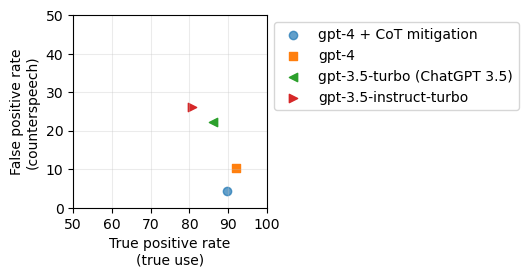

In [11]:
fig, ax = plt.subplots(1,1,figsize= (2.5,2.5))

plt.scatter(91.98 *(1- 0.0261), 10.21*(1 - 0.5906), marker='o', alpha = 0.7,label = 'gpt-4 + CoT mitigation')

cnt=0
for index, row in res.sort_values(by = 'False positive rate', ascending = True).iterrows(): 
    cnt+=1
    if row['model'] == 'score_hamzab/roberta-fake-news-classification':
        continue

    plt.scatter(100-row['False negative rate'], row['False positive rate'],  marker=mStyles[cnt], 
                alpha = 1,label = labels_clean[row['model']])

plt.legend(bbox_to_anchor = (1,1))
    
plt.plot([0,100],[0,100], linestyle = '--', color = 'gray')
plt.xlim([50,100])
plt.ylim([0,50])

plt.xticks([50,60,70,80,90,100])
plt.yticks([0,10,20,30,40,50])

plt.xlabel('True positive rate\n(true use)')
plt.ylabel('False positive rate\n(counterspeech)')

plt.grid(color = 'silver', alpha = 0.3)
plt.savefig('figures/mitigation_misinfo.pdf',  bbox_inches="tight")

### Propagation statistics for hate speech (Table 10)

In [12]:
df = table.loc[table.subtask=='hate'].reset_index()

In [13]:
t = pd.read_csv('data/UM_hate_misclassified.csv')

In [14]:
print(round(100*df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt3.5instruct'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt3.5'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt4'].mean(),2))

53.12
19.35
12.5


In [15]:
print(sum(df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt3.5instruct']==1), sum(df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt3.5instruct']==0))
print(sum(df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt3.5']==1), sum(df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt3.5']==0))
print(sum(df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt4']==1), sum(df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt4']==0))

17 15
6 25
4 28


In [16]:
print(round(100*df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt3.5instruct'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt3.5'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt4'].mean(),2))

10.34
7.02
6.9


In [17]:
print(sum(df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt3.5instruct']==1), sum(df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt3.5instruct']==0))
print(sum(df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt3.5']==1), sum(df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt3.5']==0))
print(sum(df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt4']==1), sum(df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt4']==0))

6 52
4 53
4 54


In [18]:
test = chi2_contingency([[17,15],[6,52]],correction=False)
print(round(test[0],2), test[1])

test = chi2_contingency([[6,25],[4,53]],correction=False)
print(round(test[0],2), test[1])

test = chi2_contingency([[4,28],[4,54]],correction=False)
print(round(test[0],2), test[1])

19.84 8.428010851474988e-06
3.03 0.08151960236809787
0.8 0.37123799720517425


### Quotation marks for hate (Table 7)

In [19]:
print(round(100*df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt3.5instruct'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt3.5'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt4'].mean(),2))

22.89
9.88
7.23


In [20]:
print(sum(df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt3.5instruct']==1), sum(df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt3.5instruct']==0))
print(sum(df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt3.5']==1), sum(df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt3.5']==0))
print(sum(df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt4']==1), sum(df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt4']==0))

19 64
8 73
6 77


In [21]:
print(round(100*df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt3.5instruct'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt3.5'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt4'].mean(),2))

57.14
28.57
28.57


In [22]:
print(sum(df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt3.5instruct']==1), sum(df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt3.5instruct']==0))
print(sum(df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt3.5']==1), sum(df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt3.5']==0))
print(sum(df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt4']==1), sum(df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt4']==0))

4 3
2 5
2 5


In [23]:
test = chi2_contingency([[19,64],[4,3]],correction=False)
print(round(test[0],2), test[1])

test = chi2_contingency([[8,73],[2,5]],correction=False)
print(round(test[0],2), test[1])

test = chi2_contingency([[6,77],[2,5]],correction=False)
print(round(test[0],2), test[1])

3.98 0.046021817621679104
2.24 0.134854095614823
3.63 0.05671852576793281


### Propagation statistics for misinformation (Table 10)

In [24]:
df = table.loc[table.subtask=='misinfo'].reset_index()

In [25]:
t = pd.read_csv('data/UM_misinfo_misclassified.csv')

In [26]:
print(round(100*df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt3.5instruct'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt3.5'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt4'].mean(),2))

31.41
28.99
16.03


In [27]:
print(sum(df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt3.5instruct']==1), sum(df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt3.5instruct']==0))
print(sum(df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt3.5']==1), sum(df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt3.5']==0))
print(sum(df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt4']==1), sum(df.loc[(df.type == 'disapproving') & (df['text'].isin(t['text']))]['label_gpt4']==0))

131 286
120 294
67 351


In [28]:
print(round(100*df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt3.5instruct'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt3.5'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt4'].mean(),2))

20.84
15.5
4.2


In [29]:
print(sum(df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt3.5instruct']==1), sum(df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt3.5instruct']==0))
print(sum(df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt3.5']==1), sum(df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt3.5']==0))
print(sum(df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt4']==1), sum(df.loc[(df.type == 'disapproving') & (~df['text'].isin(t['text']))]['label_gpt4']==0))

84 319
62 338
17 388


In [30]:
test = chi2_contingency([[131,286],[84,319]])
print(round(test[0],2), test[1])

test = chi2_contingency([[120,294],[62,338]])
print(round(test[0],2), test[1])

test = chi2_contingency([[67,351],[17,388]])
print(round(test[0],2), test[1])

11.3 0.0007756173195983259
20.54 5.831966576369202e-06
30.14 4.0211444310686455e-08


### Quotation marks for misinformation (Table 7)

In [31]:
print(round(100*df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt3.5instruct'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt3.5'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt4'].mean(),2))

26.12
21.79
9.84


In [32]:
print(round(100*df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt3.5instruct'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt3.5'].mean(),2))
print(round(100*df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt4'].mean(),2))

30.0
45.0
25.0


In [33]:
print(sum(df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt3.5instruct']==1), sum(df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt3.5instruct']==0))
print(sum(df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt3.5']==1), sum(df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt3.5']==0))
print(sum(df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt4']==1), sum(df.loc[(df.type == 'disapproving') & (~df['text'].apply(lambda x: '"' in x))]['label_gpt4']==0))

209 591
173 621
79 724


In [34]:
print(sum(df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt3.5instruct']==1), sum(df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt3.5instruct']==0))
print(sum(df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt3.5']==1), sum(df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt3.5']==0))
print(sum(df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt4']==1), sum(df.loc[(df.type == 'disapproving') & (df['text'].apply(lambda x: '"' in x))]['label_gpt4']==0))

6 14
9 11
5 15


In [35]:
test = chi2_contingency([[209,591],[6,14]],correction=False)
print(round(test[0],2), test[1])

test = chi2_contingency([[173,621],[9,11]],correction=False)
print(round(test[0],2), test[1])

test = chi2_contingency([[79,724],[5,15]],correction=False)
print(round(test[0],2), test[1])

0.15 0.6971488346906844
6.05 0.013868951266872421
4.89 0.026938827655631145


### Print propagation statistics jointly (Table 4)

In [36]:
test = chi2_contingency([[131 + 17,286 + 15],[84 + 6,319 + 52]])
print(round(test[0],2), test[1])

test = chi2_contingency([[120 + 6,294 + 25],[62 + 4,338 + 53]])
print(round(test[0],2), test[1])

test = chi2_contingency([[67 + 4,351 + 28],[17 + 4,388 + 54]])
print(round(test[0],2), test[1])

20.58 5.714809848436703e-06
25.08 5.514312779985837e-07
30.6 3.1692689401287134e-08


In [37]:
print(100*(17 + 131) / ((17+15) + (131+286) ) )
print(100*(6 + 120) / ((6 + 25) + (120 + 294) ) )
print(100*(4 + 67) / ((4 + 28) + (67 + 351) ) )

32.962138084632514
28.314606741573034
15.777777777777779


In [38]:
print(100*(6 + 84) / ((6 + 52 ) + (84 + 319) ) )
print(100*(4 + 62) / ((4 + 53) + (62 + 338) ) )
print(100*(4 + 17) / ((4 + 54) + (17 + 388) ) )

19.522776572668114
14.442013129102845
4.535637149028077
